<a href="https://colab.research.google.com/github/vargamartonaron/nma_23_rnn/blob/Excitation_Inhibition/Copy_of_RNN_working_memory_Dale's_law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim

In [ ]:
device = torch.device('cuda')

In [ ]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
# model['N'] = 1000  # number of neurons
model['N_ex'] = 100  # number of excitatory neurons
model['N_in'] = 900  # number of inhibitory neurons
model['N'] = model['N_ex'] + model['N_in']

# model['g'] = 0.95  # gain of synaptic weights in pool
model['g_ex'] = 0.95  # gain of excitatory synaptic weights in pool
model['g_in'] = 0.95  # gain of inhibitory synaptic weights in pool

model['sp_ex'] = 0.25  # fraction of excitatory weights that are nonzero
model['sp_in'] = 0.25  # fraction of inhibitory weights that are nonzero
model['tau'] = 20 # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
# model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['spIn'] = 50 / model['N_ex'] # Assume we need 100 excitatory neurons to receive inputs
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

burnIn_steps = int(model['burnIn'] / model['dt'])
durIn_steps = int(model['durIn'] / model['dt'])
ISI_steps = int(model['ISI'] / model['dt'])

In [ ]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = abs(np.random.normal(0, 1, size=(model['N'], model['N_ex'])))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N_ex'])) <= model['sp_ex']

model['J_ex'] = np.multiply(randMat, spMat) * model['g_ex'] / math.sqrt(model['N_ex'] * model['sp_ex'])

randMat  = -abs(np.random.normal(0, 1, size=(model['N'], model['N_in'])))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N_in'])) <= model['sp_in']

model['J_in'] = np.multiply(randMat, spMat) * model['g_in'] / math.sqrt(model['N_ex'] * model['sp_in'])

model['J'] = np.hstack((model['J_ex'], model['J_in']))
print(model['J'].shape)

# Different excitatory and inhibitory gains
# model['J'] = np.multiply(randMat, spMat) / math.sqrt(model['N'] * model['sp'])
# model['J'] = np.where(model['J'] >= 0, model['J'] * model['g_ex'], model['J'] * model['g_in'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N_ex'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N_ex'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

model['Jin'] = np.vstack((model['Jin'], np.zeros((model['N_in'], model['nIn']))))
print(model['Jin'].shape)

(1000, 1000)
(1000, 20)


In [ ]:
# # Create the synaptic weight matrix for excitatory connections.
# randMatE = np.random.normal(0, 1, size=(model['Ne'], model['Ne']))
# spMatE = np.random.uniform(0, 1, size=(model['Ne'], model['Ne'])) <= model['sp']
# model['Jee'] = np.multiply(randMatE, spMatE) * model['g'] / math.sqrt(model['Ne'] * model['sp'])

# # Create the synaptic weight matrix for excitatory to inhibitory connections.
# randMatEI = np.random.normal(0, 1, size=(model['Ni'], model['Ne']))
# spMatEI = np.random.uniform(0, 1, size=(model['Ni'], model['Ne'])) <= model['sp']
# model['JeI'] = np.multiply(randMatEI, spMatEI) * model['g'] / math.sqrt(model['Ne'] * model['sp'])

# # Create the synaptic weight matrix for inhibitory to excitatory connections.
# randMatIE = np.random.normal(0, 1, size=(model['Ne'], model['Ni']))
# spMatIE = np.random.uniform(0, 1, size=(model['Ne'], model['Ni'])) <= model['sp']
# model['JIe'] = np.multiply(randMatIE, spMatIE) * model['g'] / math.sqrt(model['Ni'] * model['sp'])

# # Create the synaptic weight matrix for inhibitory connections.
# randMatI = np.random.normal(0, 1, size=(model['Ni'], model['Ni']))
# spMatI = np.random.uniform(0, 1, size=(model['Ni'], model['Ni'])) <= model['sp']
# model['Jii'] = np.multiply(randMatI, spMatI) * model['g'] / math.sqrt(model['Ni'] * model['sp'])

In [ ]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)
  # sum = W @ X1 + Win @ input
  # X2 = activation(sum + (X1 - sum)*dt)
  # X2 = activation(sum)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * burnIn_steps

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(ISI_steps):
      input_stream.append(0)
    for t in range(durIn_steps):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

In [ ]:
# Look at an example input stream.

# onehot, stream = make_input(50, model)

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
# ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
# ax[0].set_xlabel('time (ms)')
# ax[0].set_ylabel('input value')

# ax[1].imshow(onehot[:, omit:], aspect='auto')
# ax[1].set_xlabel('time (ms)')
# ax[1].set_ylabel('input one-hot encoding')
# fig.show()

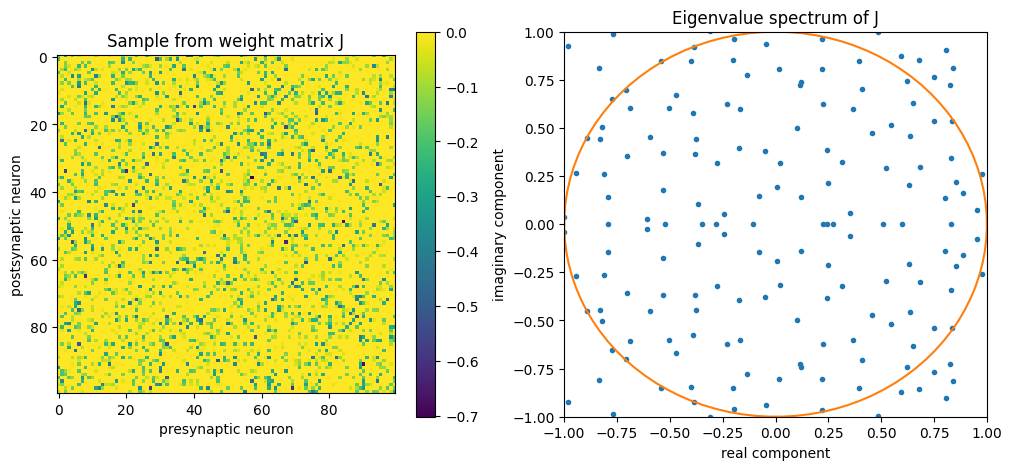

In [ ]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 1000  # portion of J to actually show (for readability)
# h = ax[0].imshow(model['J'][:showCount,:showCount])
h = ax[0].imshow(model['J'][:100,150:250])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1

ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

In [ ]:
# Simulate the model activity.

# generate the input to the model
n_stimuli = 5000
onehot, input_stream = make_input(n_stimuli, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


# fig, ax = plt.subplots(2, 1, figsize=(8, 12))
# simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
# ax[0].plot(simulation_time, input_stream)
# ax[0].set_xlabel('Time (ms)')
# ax[0].set_ylabel('Input value')

# extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
# ax[1].imshow(firing_rates, aspect='auto', extent=extents)
# ax[1].set_xlabel('Time (ms)')
# ax[1].set_ylabel('Neurons')
# fig.show()

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
# ax[0].plot(np.arange(len(input_stream) - omit) * model['dt'], input_stream[omit:])
# ax[0].set_xlabel('time (ms)')
# ax[0].set_ylabel('input value')

# ax[1].imshow(onehot[:, omit:], aspect='auto')
# ax[1].set_xlabel('time (ms)')
# ax[1].set_ylabel('input one-hot encoding')
# fig.show()

In [ ]:
def take_data(steps_back=0, inputs_back=0):

  # Make data to analyze

  input_0_idx = np.arange( burnIn_steps + durIn_steps*(1+inputs_back) - 1, onehot.shape[1], durIn_steps)
  response = firing_rates[:,input_0_idx - steps_back].T
  stimuli = onehot[:,input_0_idx - (durIn_steps*inputs_back)].T

  resp_tensor = torch.tensor(response, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)  # add singleton dimension to make a column vector

  return split_train_test(resp_tensor, stimuli_tensor)

In [ ]:
# ## Set random seeds for reproducibility

def split_train_test(resp_tensor, stimuli_tensor):
  n_stimuli = len(stimuli_tensor)

  # Split data into training set and testing set
  n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
  ishuffle = torch.randperm(n_stimuli)
  itrain = ishuffle[:n_train]  # indices of data samples to include in training set
  itest = ishuffle[n_train:]  # indices of data samples to include in testing set

  resp_train = resp_tensor[itrain]
  stimuli_train = stimuli_tensor[itrain]
  resp_test = resp_tensor[itest]
  stimuli_test = stimuli_tensor[itest]

  # print(stimuli_test.shape, resp_test.shape, stimuli_train.shape, resp_train.shape)

  return resp_train, stimuli_train, resp_test, stimuli_test

In [ ]:
class DeepNetSoftmax(nn.Module):
  """ network without hidden layers and softmax output"""

  def __init__(self, n_inputs, n_outputs=model['nIn'], n_hidden_1=0, n_hidden_2=0, ):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden_1) # neural activity --> hidden units
    self.in_ReLU = nn.ReLU()
    if n_hidden_2 != 0:
      self.hidden_layer = nn.Linear(n_hidden_1, n_hidden_2) # hidden units --> output
      self.hidden_ReLU = nn.ReLU()
      self.out_layer = nn.Linear(n_hidden_2, n_outputs)
    else:
      self.out_layer = nn.Linear(n_hidden_1, n_outputs)

    # self.in_layer = nn.Linear(n_inputs, n_outputs) # neural activity --> hidden units
    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    x = self.in_layer(x)
    x = self.in_ReLU(x)
    if n_hidden_2 != 0:
      x = self.hidden_layer(x) # r is size (n_inputs, )
      x = self.hidden_ReLU(x)
    x = self.out_layer(x)

    return x

In [ ]:
# def plot_train_loss(output_keys, output_values):

#   print(f'{k}: {v[-1]}\n' for (k, v) in (output_keys, output_values))

#   for (key, value) in (output_keys, output_values):
#     plt.plot(value, label=key)
#   # plt.plot(train_loss, label='train loss')
#   # plt.plot(test_loss, label='test loss')
#   # plt.plot(train_accuracy, label='train accuracy')
#   # plt.plot(test_accuracy, label='test accuracy')
#   plt.xlim([0, None])
#   plt.ylim([0, None])
#   plt.legend(loc='best')
#   plt.xlabel('iterations of gradient descent')
#   plt.ylabel('mean squared error')
#   plt.show()



In [ ]:
def plot_accuracy(accuracies, title=None):

  fig, ax = plt.subplots(2, 1, figsize=(8, 12))

  print(f't-{i}: {accuracies[i][-1]}\n\n' for i in range(len(accuracies)))

  for i in range(len(accuracies)):
    ax[0].plot(accuracies[i], label=f'Input at t-{i}')

  ax[0].legend(loc='best')
  ax[0].set_xlabel('iterations of gradient descent')
  ax[0].set_ylabel('accuracy')
  ax[0].set_title(title)

  ax[1].plot(best_accuracies)
  ax[1].set_xlabel('input at t-steps')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('Memory decay')

  plt.show()

In [ ]:
# compute network output from inputs in test_data
def compute_accuracy(labels, out):
  # out = net(data.unsqueeze(1))
  # if out.shape != labels.shape:
  #   labels = labels.unsqueeze(1)

  my_hit = torch.argmax(out, 1)
  true_hit =  torch.argmax(labels, 1)

  hits = my_hit == true_hit
  n_trials = labels.shape[0]

  accuracy = sum(hits) / n_trials

  return accuracy


In [ ]:
def train(net, loss_fn, train_data, train_labels, test_data, test_labels,
          n_epochs=800, learning_rate=1e-0):

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # print(out.shape, train_labels.shape)
    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar
    train_accuracy.append(compute_accuracy(train_labels, out))

    with torch.no_grad():
      # compute network output from inputs in test_data
      out = net(test_data)

      # evaluate loss function
      loss = loss_fn(out, test_labels)
      test_loss.append(loss.item())

      # evaluate accuracy
      test_accuracy.append(compute_accuracy(test_labels, out))

  return train_loss, test_loss, train_accuracy, test_accuracy


# Set random seeds for reproducibility
# np.random.seed(1)
# torch.manual_seed(1)

n_hidden_1 = 140
n_hidden_2 = 0
# Initialize network with 1000 inputs and no hidden layers
net = DeepNetSoftmax(model['N'], model['nIn'], n_hidden_1, n_hidden_2)

# Initialize cross entropy loss function
loss_fn = nn.CrossEntropyLoss()

output_keys = ['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy']
outputs = {k: [] for k in output_keys}
num_trials = (0, 5)
# steps_back = 1
best_accuracies = []

for i in range(*num_trials):

  data = take_data(inputs_back=i)   #resp_train, stimuli_train, resp_test, stimuli_test
  output_values = [*train(net, loss_fn, *data)]
  output = dict(zip(output_keys, output_values))

  outputs['train_accuracy'].append(output['train_accuracy'])
  outputs['test_accuracy'].append(output['test_accuracy'])
  best_accuracy = output['test_accuracy'][-1]
  best_accuracies.append(best_accuracy)

  # reset all parameters
  for layer in net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

  print(f'Input t-{i} test accuracy: {best_accuracy}')
# Run gradient descent on data
# train_loss, test_loss, train_accuracy, test_accuracy = train(net, loss_fn, resp_train, stimuli_train, resp_test, stimuli_test)
# print(f'k: {v[-1]}\ntest_loss: {test_loss[-1]}\ntrain_accuracy: {train_accuracy[-1]}\ntest_accuracy: {test_accuracy[-1]}')



Input t-0 test accuracy: 0.8989999890327454
Input t-1 test accuracy: 0.19850000739097595
Input t-2 test accuracy: 0.12549999356269836
Input t-3 test accuracy: 0.11955977976322174
Input t-4 test accuracy: 0.10755378007888794


<generator object plot_accuracy.<locals>.<genexpr> at 0x7f88056b5cb0>


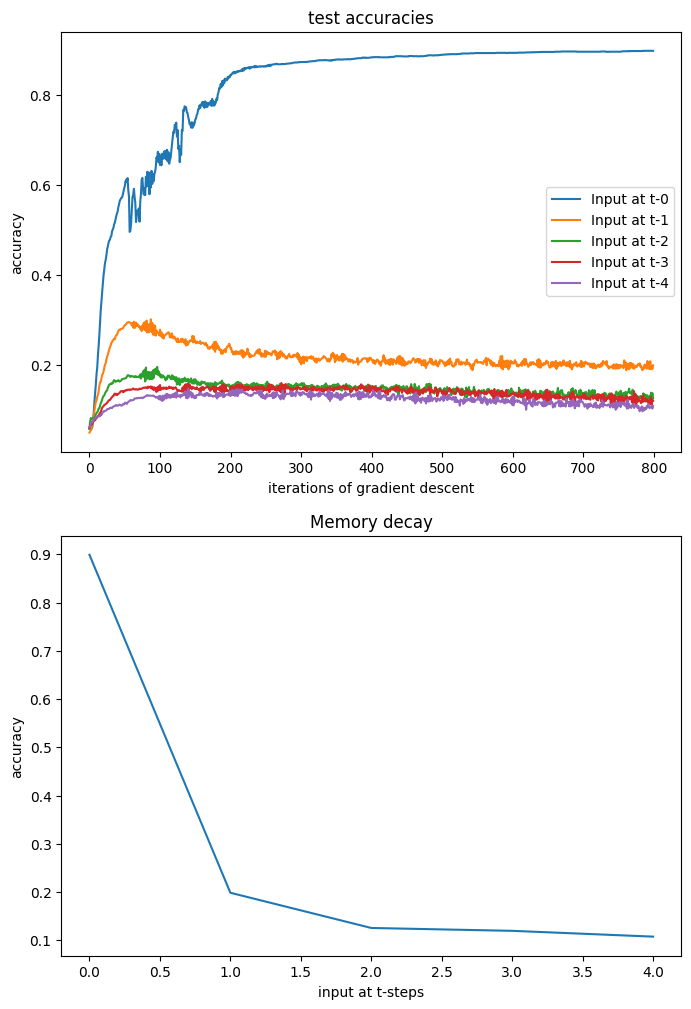

In [ ]:
# Plot the training and test loss over iterations of GD

# plot_train_loss(output.keys(), output.values())
# plot_accuracy(outputs['train_accuracy'], title='train accuracies')
plot_accuracy(outputs['test_accuracy'], title='test accuracies')

In [ ]:
print(outputs['test_accuracy'][1][-1])

tensor(0.1985)


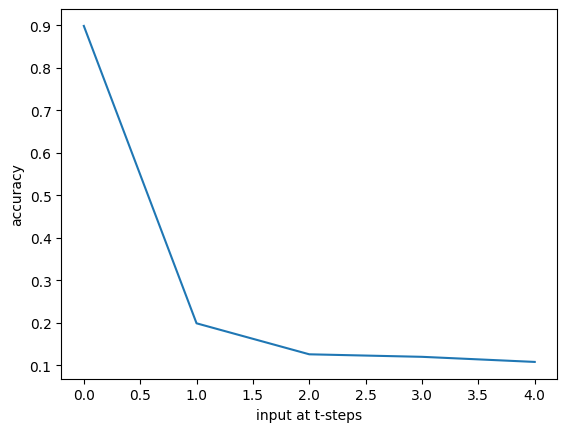

In [ ]:
plt.plot(best_accuracies)
plt.xlabel('input at t-steps')
plt.ylabel('accuracy')
plt.show()